In [1]:
# Import libraries

# Math stuff
import numpy as np
import math

# Plotting stuff
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline

# ODE stuff
from scipy.integrate import solve_ivp

In [2]:
# Constants
g = -9.81  # gravitational acceleration
k = 3     # spring strength
l0 = 4    # rest length of the spring
m1 = 1    # mass of projectile 1
m2 = 5    # mass of projectile 2


# Dynamics function for the ODE
def dynamics_function(t, z):
    # The dynamics function accepts time t and vector z as input, and
    # returns the resulting vector of derivative values given
    # by z' (i.e., the vector dzdt)

    # the entries of the incoming z vector will contain the following data
    # z[0] = x-position of projectile 1, x1(t)
    # z[1] = y-position of projectile 1, y1(t)
    # z[2] = x-position of projectile 2, x2(t)
    # z[3] = y-position of projectile 2, y2(t)
    # z[4] = x-velocity of projectile 1, u1(t)
    # z[5] = y-velocity of projectile 1, v1(t)
    # z[6] = x-velocity of projectile 2, u2(t)
    # z[7] = y-velocity of projectile 2, v2(t)
    # this is essentially the current state of the ODE system

    # create the empty z' vector
    dzdt = np.zeros(8)

    # *************
    # TODO HERE: Fill 'dzdt' with a vector of the necessary derivative data according to the problem's dynamics function,
    #            consistent with the ordering of variables listed above

    x1, y1, x2, y2 = z[0], z[1], z[2], z[3]
    u1, v1, u2, v2 = z[4], z[5], z[6], z[7]

    # Compute current spring length
    dx = x1 - x2
    dy = y1 - y2
    l_cur = np.sqrt(dx**2 + dy**2)

    # Compute unit direction vector of the spring
    d = np.array([dx, dy]) / l_cur

    # Compute forces
    F12 = -k * (l_cur - l0) * d
    F21 = -F12

    # Compute accelerations
    a1_x = F12[0] / m1
    a1_y = g + F12[1] / m1
    a2_x = F21[0] / m2
    a2_y = g + F21[1] / m2

    dzdt[0] = u1  # x1' = u1
    dzdt[1] = v1  # y1' = v1
    dzdt[2] = u2  # x2' = u2
    dzdt[3] = v2  # y2' = v2
    dzdt[4] = a1_x  # u1' = a1_x
    dzdt[5] = a1_y  # v1' = a1_y
    dzdt[6] = a2_x  # u2' = a2_x
    dzdt[7] = a2_y  # v2' = a2_y

    # *************

    # return the vector for SciPy's solver to use.
    return dzdt

In [3]:
# We'll also define an "event function" to terminate the simulation
# when one of the two projectiles first hits the ground (y=0).
# The IVP solver will check this condition behind the scenes for us, based on the function below.
def ground_event(t, z):
    # *************
    # TODO HERE: set the variable 'miny' to the lower of the two y-values of the two objects,
    miny = min(z[1], z[3])

    # *************
    return miny


ground_event.terminal = True  # halt on impact (when the lower of the two objects hits y=0)
ground_event.direction = -1  # only count positive-to-negative crossings of the height (y)

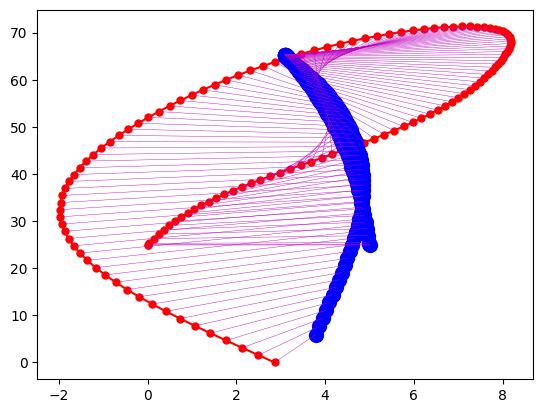

In [4]:
# Set up the information needed to solve the initial value problem

# *************
# TODO HERE: Fill the vector z0 below with the necessary initial state data.
#            Refer to the comment in the dynamics_function for the ordering of variables.

z0 = [0, 25,   # x1, y1 (position of projectile 1)
      5, 25,   # x2, y2 (position of projectile 2)
      2, 20,   # u1, v1 (velocity of projectile 1)
      -1/2, 30]  # u2, v2 (velocity of projectile 2)

# *************

# Specify the timespan for simulation. We simulate from 0 to 30 (unless an *event* happens first!)
tspan = [0, 30]

# Below we call the SciPy's numerical IVP solver to solve the problem
# It takes in the dynamics function, desired time range, and the initial conditions z0
# It then calculates a vector of discrete times, sol.t,
# and corresponding vectors of discrete solution data sol.y
# It also uses adaptive timestepping - but we'll limit the max step size to 0.05 so we see plenty of steps
# Finally, we specify the ground_event to halt when the objects hit the ground.
sol = solve_ivp(dynamics_function, tspan, z0, max_step=0.05, events=ground_event)

# display the resulting motion as a static image
# y_target = np.full_like(sol.y[4], 0)

# plot path of projectiles
plt.plot(sol.y[0], sol.y[1], 'r-o', markersize=5)  # lighter
plt.plot(sol.y[2], sol.y[3], 'b-o', markersize=10)  # heavier

# plot a line for the spring at each time
for i in range(len(sol.t)):
    plt.plot([sol.y[0][i], sol.y[2][i]], [sol.y[1][i], sol.y[3][i]], 'm-', linewidth=0.3)

plt.show()

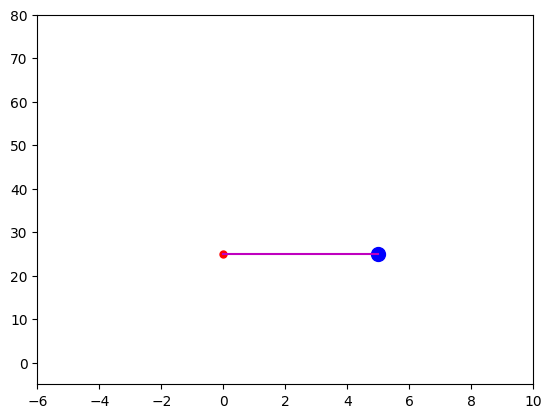

In [5]:
# display the result as an actual animation, to see the motion and enjoy increased amounts of fun
from IPython.display import HTML
x = sol.y[0]
y = sol.y[1]

x2 = sol.y[2]
y2 = sol.y[3]

fig, ax = plt.subplots()
ax.axis([-6, 10, -5, 80])
l, = ax.plot([], [])
dots, = ax.plot([], [], 'r.', markersize=10)

l2, = ax.plot([], [])
dots2, = ax.plot([], [], 'b.', markersize=20)

line, = ax.plot([], [], 'm-')


def animate(i):
    l.set_data([x[i]], [y[i]])
    dots.set_data([x[i]], [y[i]])
    l2.set_data([x2[i]], [y2[i]])
    dots2.set_data([x2[i]], [y2[i]])
    line.set_data([x[i], x2[i]], [y[i], y2[i]])


ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(x))

HTML(ani.to_jshtml())  # use javascript player
# HTML(ani.to_html5_video())  #use html5 video

# You can try writing the file to disk as a video using the code below, if you have ffmpeg set up
# or maybe make further modifications to produce an animated GIF.
# FFwriter = matplotlib.animation.FFMpegWriter(fps=30)
# ani.save('animation.mp4', writer = FFwriter)